In [1]:
# General Dependencies
import numpy as np
import scipy.io as io

# Preprocessing Dependencies
from trefide.utils.noise import estimate_noise

# CPP Wrapper Dependencies
from trefide.pmd import parallel_batch_pmd, serial_batch_pmd

# Experimental Implementation Dependencies
from trefide.temporal import TrendFilter
from trefide.utils.greedyPCA import choose_rank
from prox_tv import tv1_2d

# Plotting & Video Dependencies
import matplotlib.pyplot as plt
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc, imshow

%load_ext autoreload
%autoreload 2

# functions to migrate

In [2]:
def eval_tv(image):
    return np.sum(np.abs(image[1:,:] - image[:-1,:])) + np.sum(np.abs(image[:,1:] - image[:,:-1]))

In [3]:
def play(movie, gain=3, fr=120, offset=0, magnification=3):
    maxmov = np.max(movie)
    looping=True
    terminated=False
    while looping:
        for t in range(350, 1000):
            if magnification != 1:
                frame = cv2.resize(movie[:,:,t],
                                   None,
                                   fx=magnification,
                                   fy=magnification,
                                   interpolation=cv2.INTER_LINEAR)
            imshow('frame', (frame - offset) / maxmov*gain)
            if cv2.waitKey(int(1. / fr * 1000)) & 0xFF == ord('q'):
                looping = False
                terminated = True
                break
        if terminated:
            break

    cv2.waitKey(100)
    cv2.destroyAllWindows()
    for i in range(10):
        cv2.waitKey(100)

# Load Data & Set Params

In [4]:
X = np.load("../data/prepared_sampleMovie.npy")
d1, d2, T = X.shape

In [5]:
max_components = 20
maxiter=50
tol = 5e-3
bheight = 20
bwidth = 100
spatial_cutoff = (bheight*bwidth / ((bheight*(bwidth-1) + bwidth*(bheight-1))))
w=.0025

# Decompose In Parallel

In [6]:
U, V, K, indices = serial_batch_pmd(d1, d2, T, X, bheight, bwidth, w, spatial_cutoff, max_components, maxiter, tol)
#U, V, K, indices = parallel_pmd(d1, d2, T, X, bheight, bwidth, w, spatial_cutoff, max_components, maxiter, tol)

In [7]:
K

array([ 3,  4,  6,  7,  3,  4,  5,  3,  7,  8, 10,  3,  7,  9,  8,  7,  8,
        5,  4,  4,  1,  4,  5,  7,  9,  6,  6,  4,  2,  3,  4,  4],
      dtype=uint64)

# Test Temporal Components

# Inspect Results

## Plots

### Patch Ranks

In [ ]:
# TODO MAKE PLOT
K

### Component Quality

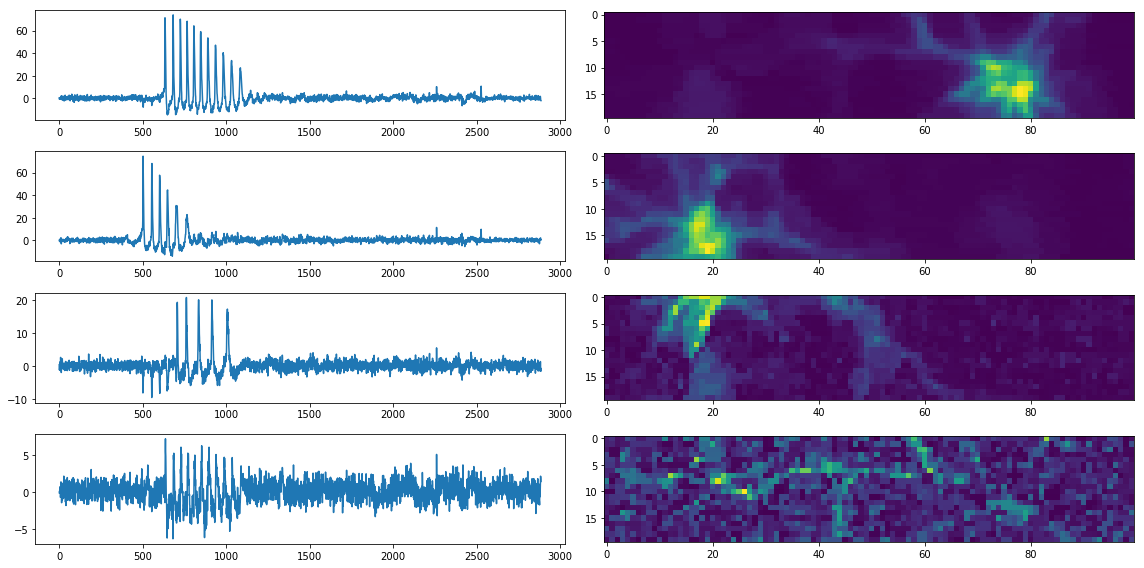

In [8]:
b_idx = -1
fig, ax = plt.subplots(int(K[b_idx]), 2, figsize=(16, 2*int(K[b_idx])))
for k in range(int(K[b_idx])):
    ax[k,0].plot(np.arange(T), V[b_idx, k, :])
    ax[k,1].imshow(np.abs(U[b_idx,:,:,k]))
    #ax[k,0].set_title("Temporal component {}, Passed: {}".format(k, not k in temporal_failed))
    #ax[k,1].set_title("Spatial component {}, Passed: {}".format(k,k < K_prev[b_idx]))
plt.tight_layout()
plt.show()

### Correlation Plots

## Videos

### Full Movie

In [8]:
reconstructed = np.zeros(np.prod(X.shape)).reshape(X.shape)
for b_idx, num_components in enumerate(K):
    for k in range(num_components):
        idx, jdx = indices[b_idx]
        idx *= bheight
        jdx *= bwidth
        reconstructed[idx:idx+bheight, jdx:jdx+bwidth] += \
            U[b_idx,:,:,k][:,:,None].dot(V[b_idx,k,:][None,:]).reshape((bheight,bwidth,T), order='F')

TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
from trefide.pmd import reconstruct_movie

In [ ]:
indices.dtype

In [ ]:
reconstructed = reconstruct_movie(U,V,K, indices.astype(np.uint64))

In [ ]:
V.shape

In [ ]:
play(np.vstack([X, reconstructed, X - reconstructed]), magnification=2)

### Single Patch

In [ ]:
b_idx
denoised = U[b_idx,:,:,:K[b_idx]].dot(V[b_idx, :K[b_idx],:]).reshape((bheight,bwidth,T), order='F')
idx, jdx = indices[b_idx]
idx *= bheight
jdx *= bwidth
raw = X[idx:idx+bheight, jdx:jdx+bwidth]
residual = raw - denoised
play(np.vstack([raw, denoised, residual]), magnification=7)

In [ ]:
play(np.vstack([reconstructed]), magnification=2)